# Predicting the Likelihood of Heart Disease based on Age, Cholestrol and ST Depression of an Individual 

#### Lisa Li, Jovan Kannitho, Justin An, Tammy Ou

## Introduction

Heart disease, a leading cause of death, are health conditions that affect the heart or blood vessels. With such pertinence, identifying consistent predictors for heart disease is crucial.

For our analysis, we consider seldom analyzed data from the Heart Disease Dataset (Janosi et al., 1988), specifically the VA Long Beach Dataset. While 76 attributes complete the dataset, only 14 are used attributes are used in publications due to their predictive relevance. We aim to apply the knn-classification algorithm to this dataset to answer the question: **Based on st depression, age and resting blood pressure, can we predict whether an individual will develop heart disease?**


In [1]:
#install.packages("psych")
#install.packages("ggcorrplot")
library(tidyverse)
library(tidymodels)
library(dplyr)
library(RColorBrewer)
library(kknn)
library(psych)
library(ggcorrplot)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

### Loading and Cleaning Data

In [2]:
#reading data and changing names of the columns
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data"
column_names <- c("age",
                  "sex",
                  "chest_pain",
                  "resting_bp",
                  "cholestrol", 
                  "fasting_bp",
                  "resting_ecg",
                  "max_hrate_achieved",
                  "exercise_induced_angina",
                  "st_depression",
                  "slope",
                  "major_vessels",
                  "thalassemia", # too much iron in blood
                  "diagnosis_num") # changed from num to diagnonsis_num


va_heart_data <- read_csv(url,
                    col_names = c(column_names),
                    col_types = list("d", "f", "f", "d", "d", "f", "f", "d", "f", "d", "f", "i", "f", "d")) 

# changed diagnosis levels of 0-4 to True and False 
# if True -> presence of heart disease (original values 1-4) , False -> absence of heart disease (original value of 0)
va_heart_data_clean <- va_heart_data |>
    mutate(diagnosis = diagnosis_num > 0) 
    
                                  
#changing all unknown values (?) to NA values
# va_heart_data_clean[va_heart_data_clean == "?"] <- NA

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”


### Cleaning Dataset

In [3]:
# Omiting columns which have mostly NA values
va_heart_data_clean <- va_heart_data_clean |>
    select(-thalassemia,-major_vessels)

# Omiting rows which have NA values
va_heart_data_clean <- va_heart_data_clean |>
  mutate(across(everything(), ~ifelse(. == "?", NA, .))) |>
  na.omit()


### Training and Testing Sets, and Exploratory Data Analysis

We split our data set into training (75%) and testing (25%) sets. A seed was used to ensure reproducibility.


In [4]:
set.seed(1)
va_split <- initial_split(va_heart_data_clean, prop = .75, strata = diagnosis)
va_train <- training(va_split)
va_test <- testing(va_split)

In [5]:
#split our va_train_select into two dataframes: one with our numeric (num) variables, and one with our categorical (cat) variables

va_train_numeric <- va_train |>
                        select(age, resting_bp, cholestrol, max_hrate_achieved, st_depression, diagnosis)

va_train_categoric <- va_train |>
                        select(sex, chest_pain, fasting_bp, resting_ecg, exercise_induced_angina, slope, diagnosis)
va_train_numeric

age,resting_bp,cholestrol,max_hrate_achieved,st_depression,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
66,110,213,99,1.3,FALSE
66,120,0,120,-0.5,FALSE
60,180,0,140,1.5,FALSE
63,126,0,120,1.5,FALSE
60,120,0,133,2.0,FALSE
58,132,458,69,1.0,FALSE
63,130,0,160,3.0,FALSE
64,130,223,128,0.5,FALSE
59,140,274,154,2.0,FALSE


A correlation matrix will help identify variables with the highest impact on heart disease. We use numeric variables, which are ideal with the correlational matrix and knn-algorithm. We retain the categorical variables for future use in visualizations. 

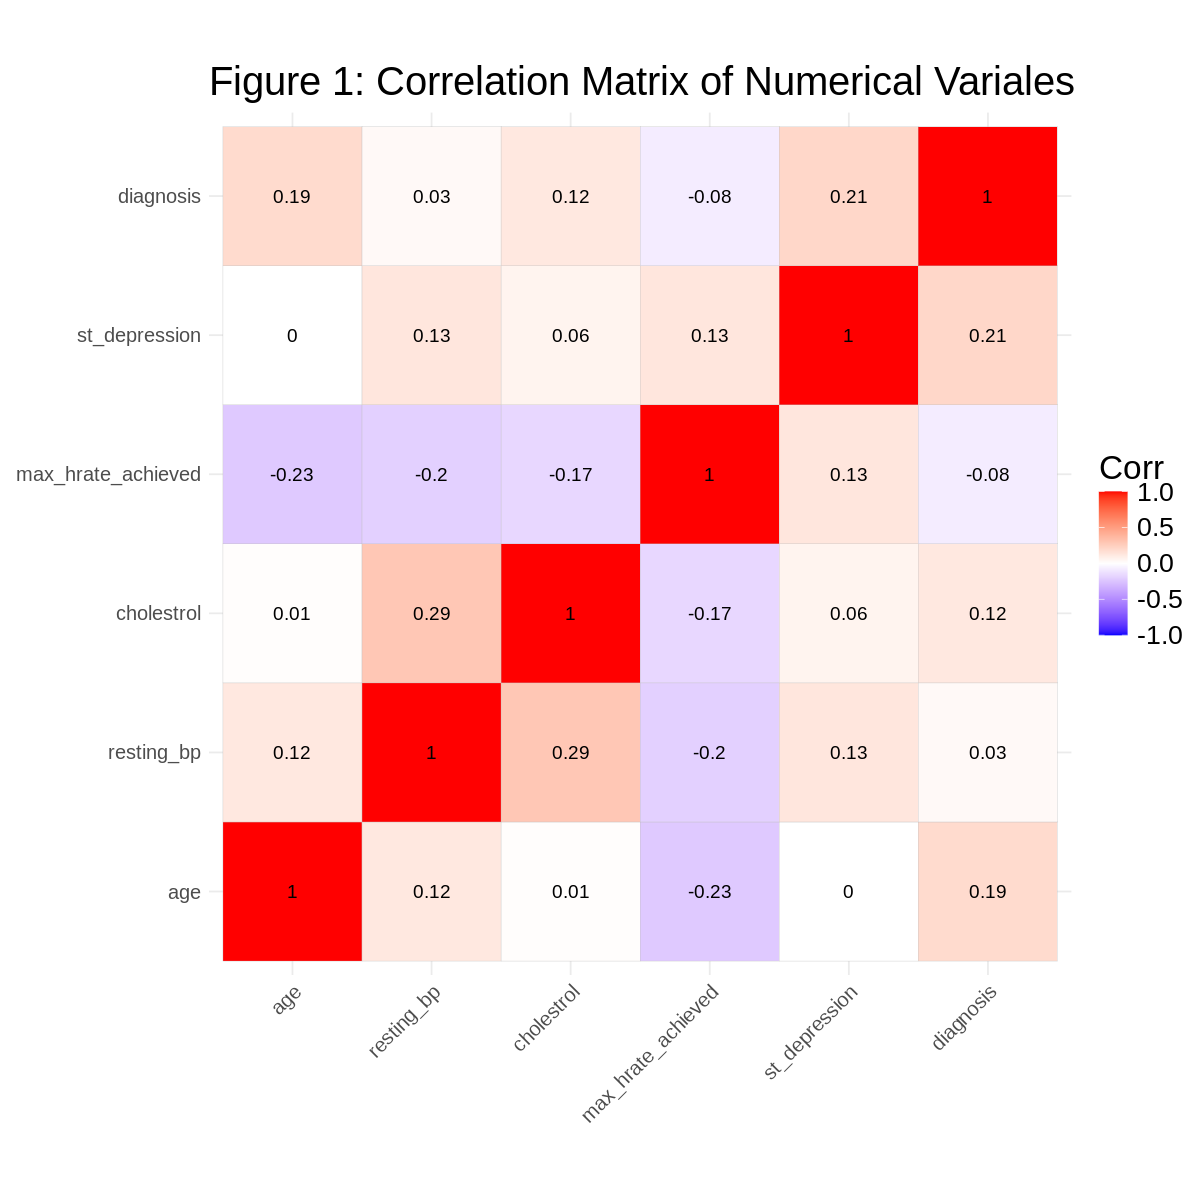

In [6]:
#making a correlation matrix of data using cor()
options(repr.plot.width = 10, repr.plot.height = 10)
correlation_matrix <- cor(va_train_numeric)

#creating a plot of the results 
ggcorrplot(correlation_matrix, lab = TRUE) + 
    labs(title = "Figure 1: Correlation Matrix of Numerical Variales") + 
    theme(text = element_text(size = 20))


We choose  st_depression, age and chole as our predictor variables, as they have the highest correlations with the outcome variable, and we will further explore them below.  

In [7]:
#selecting the 3 vairables with the highest correlation to heart disease as determined by correlation matrix
#renamed columns to increase clarity
va_heart_data_top_3 <-select(va_train_numeric, "diagnosis", "st_depression","age", "cholestrol")


In [8]:
#summarize each predictor using mean and standard deviation, grouped by diagnosis 

count_sex <- va_heart_data_top_3 |>
   group_by(diagnosis) |>
   summarize(count=n()) 

count_sex

summary_st_depression <- va_heart_data_top_3 |>
         group_by(diagnosis) |>
         summarize(mean_st_depression = mean(st_depression),
                   sd_st_depression = sd(st_depression))

summary_age <- va_heart_data_top_3 |>
         group_by(diagnosis) |>
         summarize(mean_age = mean(age), sd_age = sd(age)) 



summary_cholestrol <- va_heart_data_top_3 |>
         group_by(diagnosis) |>
         summarize(mean_cholestrol = mean(cholestrol),sd_cholestrol = sd(cholestrol))



summary_st_depression
summary_age
summary_cholestrol



diagnosis,count
<lgl>,<int>
FALSE,11
TRUE,54


diagnosis,mean_st_depression,sd_st_depression
<lgl>,<dbl>,<dbl>
FALSE,1.345455,0.8959505
TRUE,1.896296,0.9792109


diagnosis,mean_age,sd_age
<lgl>,<dbl>,<dbl>
FALSE,57.90909,9.761706
TRUE,61.14815,5.557274


diagnosis,mean_cholestrol,sd_cholestrol
<lgl>,<dbl>,<dbl>
FALSE,143.5455,154.9583
TRUE,181.0741,115.8196


We observe higher means for st_depression, age and resting_bp for individuals who have heart disease. Variability is comparable across diagnosis groups for age and resting_bp, except for st_depression. 

### Visualization of Data

We created histograms to visualize the distributions of the predictor variables and split the comparison by diagnosis. 


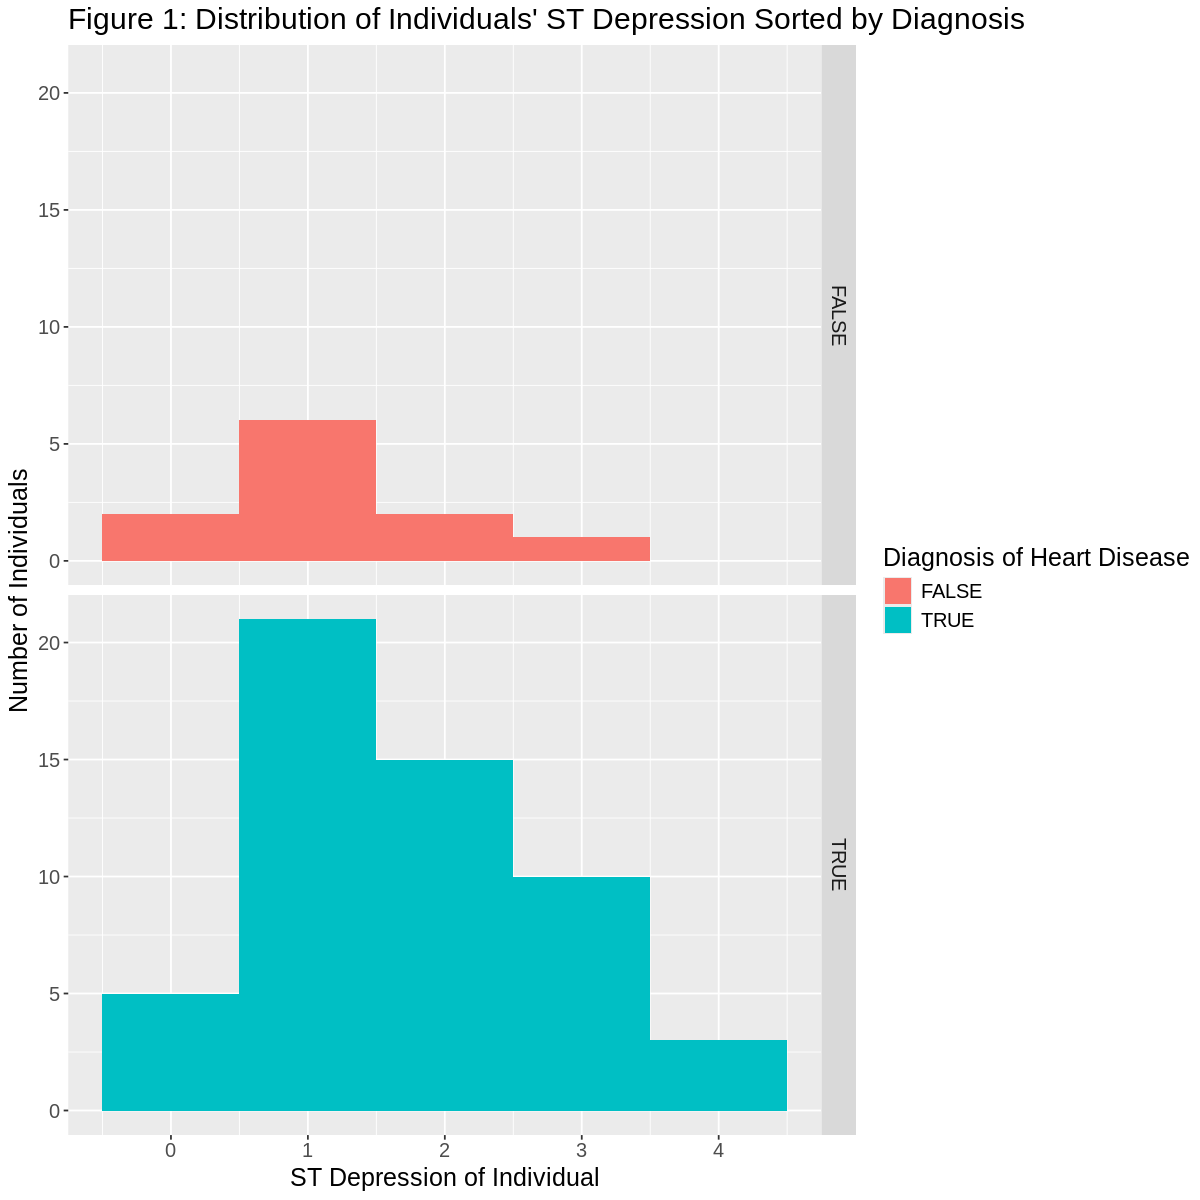

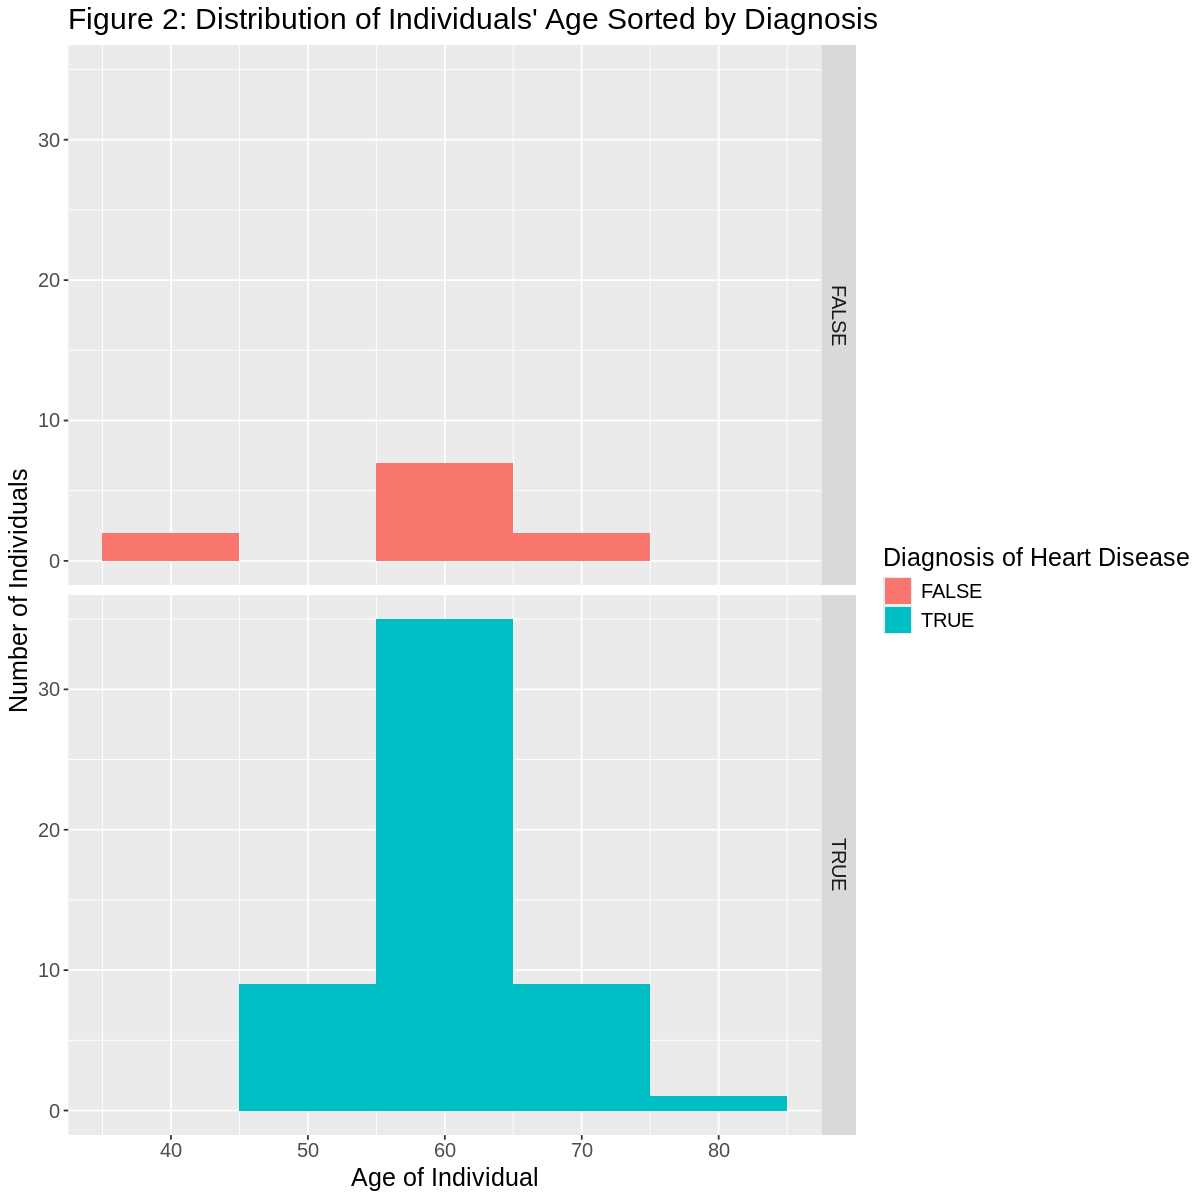

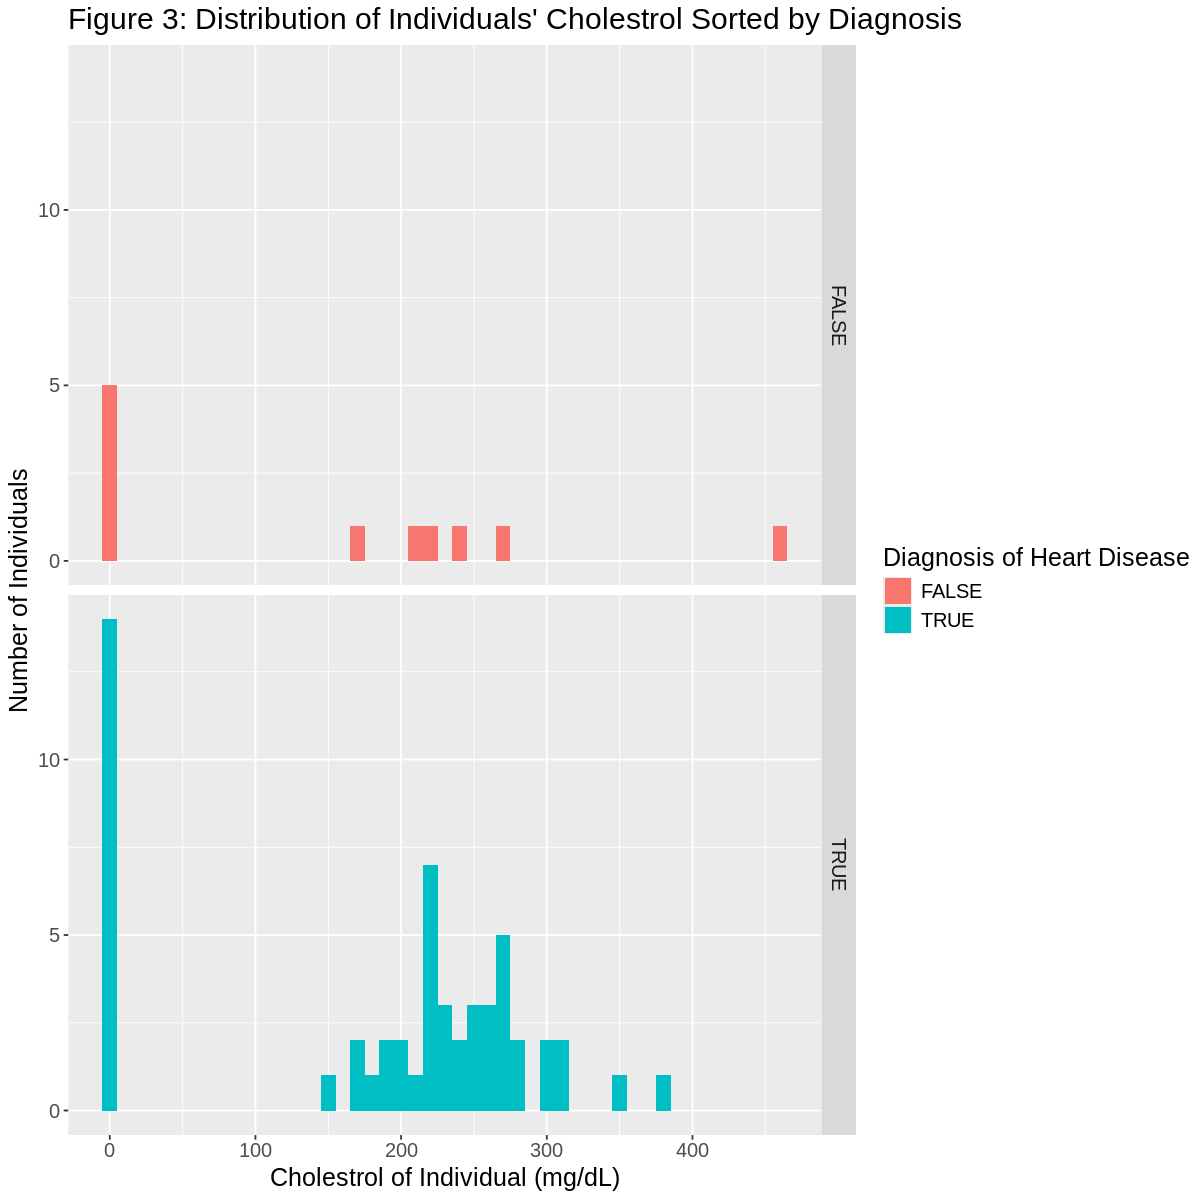

In [9]:
options(repr.plot.width = 10, repr.plot.height = 10)


st_depression_plot <- va_train_numeric |>
                       select(diagnosis, st_depression) |>
                        ggplot(aes(x = st_depression, fill=diagnosis)) +
                        geom_histogram(binwidth=1) +
                        facet_grid(rows = vars(diagnosis)) + 
                        labs (x = "ST Depression of Individual",
                              y = "Number of Individuals", 
                              fill = "Diagnosis of Heart Disease",
                              title = "Figure 1: Distribution of Individuals' ST Depression Sorted by Diagnosis") + 
                              theme(text = element_text(size = 15))
                              

age_plot <- va_train_numeric |>
                       select(diagnosis, age) |>
                        ggplot(aes(x = age, fill=diagnosis)) +
                        geom_histogram(binwidth =10) +
                        facet_grid(rows = vars(diagnosis)) +
                        labs (x = "Age of Individual",
                              y = "Number of Individuals", 
                              fill = "Diagnosis of Heart Disease", 
                              title = "Figure 2: Distribution of Individuals' Age Sorted by Diagnosis") + 
                        theme(text = element_text(size = 15))

cholestrol_plot <- va_train_numeric |>
                       select(diagnosis, cholestrol) |>
                        ggplot(aes(x = cholestrol, fill=diagnosis)) +
                        geom_histogram(binwidth =10) +
                        facet_grid(rows = vars(diagnosis)) +
                        labs (x = "Cholestrol of Individual (mg/dL)",
                              y = "Number of Individuals", 
                              fill = "Diagnosis of Heart Disease",
                              title = "Figure 3: Distribution of Individuals' Cholestrol Sorted by Diagnosis") + 
                        theme(text = element_text(size = 15))

st_depression_plot
age_plot
cholestrol_plot


The graphs above show that values for individuals with heart disease tend to be in the higher end of the distribution compared to those without heart disease (for all predictor variables). 

Lastly, as the knn-classification model uses interactions between variables to predict outcomes, we used a scatterplot to explore interactions between age and resting blood pressure. 


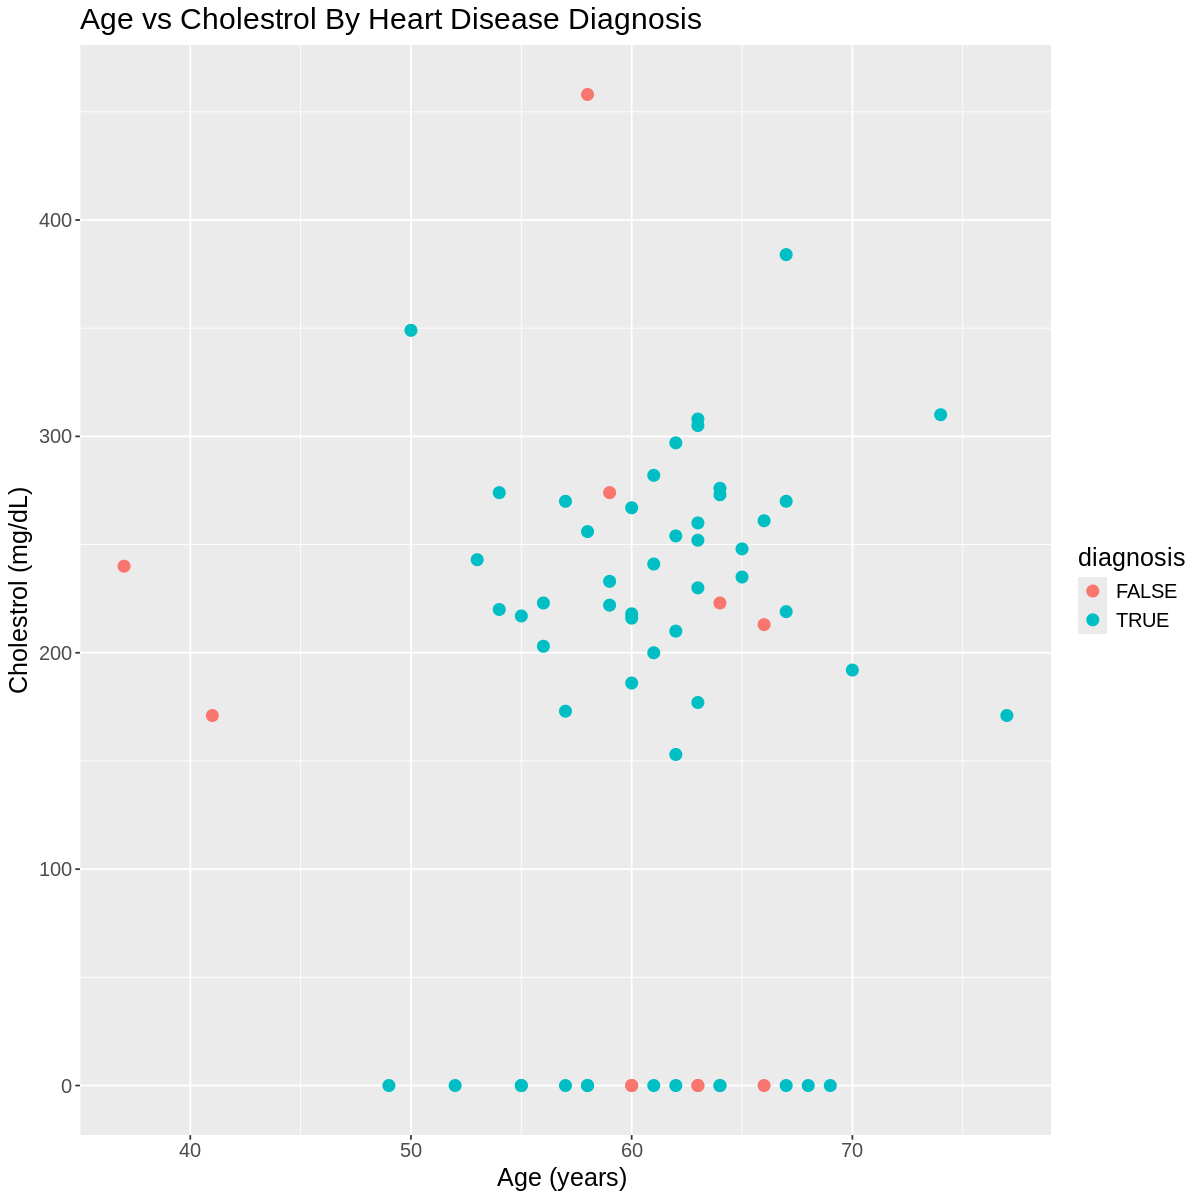

In [10]:
age_and_cholestrol_plot <- va_heart_data_top_3 |>
                           ggplot(aes(x = age, y = cholestrol, color = diagnosis)) +
                           geom_point(size = 3) +
                           labs( x= "Age (years) ", y = "Cholestrol (mg/dL)") +
                           ggtitle("Age vs Cholestrol By Heart Disease Diagnosis") +
                           theme(text = element_text(size = 15))

age_and_cholestrol_plot

The presence of heart disease is more likely at higher values of age and blood pressure. 


## Methods

1.  Read and transform data into tidy format.

2. Create knn-classification algorithm using chosen predictors.

3. Cross-validation to determine optimal k-value for accuracy.

4. Use test data and check accuracy.

5. Visualize predictor interactions and the predicted outcome, using above k-value and scatterplots. Further explore patterns with the categorical variables. 




## Expected Outcomes and Significance


*Expected Outcomes*

Based on our preliminary explorations, we expect that higher values for age, resting blood pressure, and ST depression will predict the presence of heart disease.

It is important to note that most of our exploration has been done on isolating one variable and its relation to the outcome. As the knn-model uses interactions between variables, different patterns from our initial exploration may emerge.

*Implications*

Using VA Long Beach data may indicate if results of studies using Cleveland data can generalize to other locations. If true, it can add confidence to the predictive power of the variables. Divergent findings may prompt future research into why such predictors appeared irrelevant for VA Long beach, and if exploration beyond the subset of 14 attributes is needed.


## References

Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.


## Tuning K-NN Model

In [14]:
#changing diagnosis to a factor 
va_train <- va_train |>
    mutate(diagnosis = as_factor(diagnosis))

#creating classification recipe
heart_recipe <- recipe(diagnosis ~ cholestrol + st_depression + age, data = va_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_vfold <- vfold_cv(va_train, v = 5, strata = diagnosis)


heart_metrics <- workflow() |>
                  add_recipe(heart_recipe) |>
                  add_model(heart_spec) |>
                  fit_resamples(resamples = heart_vfold) |>
                  collect_metrics()

heart_metrics


.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.8315018,5,0.01171302,Preprocessor1_Model1
roc_auc,binary,0.5984848,5,0.09848485,Preprocessor1_Model1


## Making a Classification Model

In [15]:
#changing diagnosis to a factor 
va_train <- va_train |>
    mutate(diagnosis = as_factor(diagnosis))

#creating classification recipe
heart_recipe <- recipe(diagnosis ~ cholestrol + st_depression + age, data = va_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec) |> 
    fit(data = va_train)


#using model to predict the testing data
validation_predicted <- predict(heart_fit, va_test) |>
    bind_cols(va_test)

#changing diagnosis to a factor in binded dataset
validation_predicted <- validation_predicted |>
    mutate(diagnosis = as_factor(diagnosis))

#determining the accuracy of the model
accuracy <- validation_predicted |>
    metrics(truth = diagnosis, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(.estimate) |>
    pull()

accuracy

[1] 0.8181818